# SmartMAP: MVP demo (baseline classifiers - no tuning)

## Introduction

In [1]:
import glob

import numpy as np
import pandas as pd
import os

import GeoDS

from GeoDS import hypercube
from GeoDS import utilities
from GeoDS.supervised import mapclass, pipelineator, tuning
from GeoDS import reporting 
from GeoDS.prospectivity import featureimportance
from GeoDS import eda

from sklearn.decomposition import PCA, FastICA
from sklearn.model_selection import train_test_split
import shap
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import entropy
from scipy.stats import randint as sp_randint
import scipy

from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold, StratifiedGroupKFold

from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTENC

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import lightgbm
from sklearn.svm import SVC
from catboost import CatBoostClassifier
import lightgbm
import xgboost

import importlib
from joblib import dump, load
pd.set_option('display.max_columns', None)
rand = 42

#plt.rcParamsDefault["figure.figsize"] = [20., 20.]
plt.rcParams["figure.facecolor"] = 'white'
plt.rcParams["axes.facecolor"] = 'white'
plt.rcParams["savefig.facecolor"] = 'white'

## 1 - Load HyperCube, Defined Global Variable, Create working folders


Lets define variables that are user defined and that will be reused all along the workflow.

In [2]:
crs = 'epsg:26910'
xres=25
yres=25

In [3]:
trial_name = '../3_processing/2_baseline_model_outputs'
if not os.path.exists(trial_name):
    os.makedirs(trial_name)

Lets also prepare to turn back integers categorical columns back into their original string

In [4]:
correspondance = pd.read_csv('../3_processing/AlterationIntensity_CategoryCodes.csv')
correspondance_dict = dict(zip(correspondance['Code'], correspondance['Alteration intensity']))

def replace_classes(actual_classes, correspondance_dict):
    original_classes = [correspondance_dict[code] for code in actual_classes]
    return original_classes

In [5]:
correspondance_dict

{1: 'None (0-2%)',
 2: 'Weak (2-15%)',
 3: 'Moderate (15-50%)',
 4: 'Strong (50-100%)'}

You also need to define your columns, which is your training layer and load them accordingly using Hypercube methods.

In [6]:
numeric_features = ['EM_Impulse_Dighem_MERGED_resmid_log10',
                    'PC_mag_long_1',
                    'PC_mag_long_2',
                    'PC_mag_long_3',
                    'PC_mag_long_4',
                    'PC_mag_short_1',
                    'PC_mag_short_2',
                    'PC_mag_short_4',
                    'PC_mag_short_5',
                    'PC_SA_1VD_2',
                    'PC_SA_ContrastEnh_2',
                    'PC_SA_pgrav_HGM_1',
                    'PC_texture_ContrastEnh_1',
                    'PC_texture_EM_1',
                    'PC_texture_pgravTilt_1',
                    'PC_texture_RTP_1VD_1',
                    ]


lineaments = ['Lineaments_Dist_To_Major_All_merged',
              'Lineaments_Dist_To_Major_N-S',
              'Lineaments_Dist_To_Major_NE-SW',
              'Lineaments_Dist_To_Major_NW-SE',
              'Lineaments_Major_1500m_X2_plus_Minor_500m_X1',]

categorical_features = ['SOM_AC_10clusters_PCA',
                        'SOM_AC_12clusters_ICA'
                       ]

targets= ['Targets_multiclass_alteration_intensity_BUFF',
          'Targets_multiclass_alteration_intensity_BUFF_IDs'
         ]

TARGET_IDs = 'Targets_multiclass_alteration_intensity_BUFF_IDs'
TARGET = 'Targets_multiclass_alteration_intensity_BUFF'

coords = ['x', 'y']

columns = {
    'numeric_features' : numeric_features,
    'lineaments' : lineaments,
    'categories' : categorical_features,
    'targets' : targets,
    'coordinates' : coords    
}

In [7]:
cube = hypercube.HyperCube(input_data='../2_cubes/Artemis_ThematicPCA_cube.csv',
                           x_field='x', y_field='y', crs=crs, columns_dict=columns)

Using pandas to read the csv file!


In [8]:
cube.summary()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1075678 entries, 0 to 1075677
Data columns (total 27 columns):
 #   Column                                            Non-Null Count    Dtype  
---  ------                                            --------------    -----  
 0   y                                                 1075678 non-null  float64
 1   x                                                 1075678 non-null  float64
 2   EM_Impulse_Dighem_MERGED_resmid_log10             1075678 non-null  float64
 3   Lineaments_Dist_To_Major_All_merged               1075678 non-null  float64
 4   Lineaments_Dist_To_Major_N-S                      1075678 non-null  float64
 5   Lineaments_Dist_To_Major_NE-SW                    1075678 non-null  float64
 6   Lineaments_Dist_To_Major_NW-SE                    1075678 non-null  float64
 7   Lineaments_Major_1500m_X2_plus_Minor_500m_X1      1075678 non-null  float64
 8   PC_mag_long_1                                     1075678 non-null  floa

In [9]:
cube.df.describe()

,y,x,EM_Impulse_Dighem_MERGED_resmid_log10,Lineaments_Dist_To_Major_All_merged,Lineaments_Dist_To_Major_N-S,Lineaments_Dist_To_Major_NE-SW,Lineaments_Dist_To_Major_NW-SE,Lineaments_Major_1500m_X2_plus_Minor_500m_X1,PC_mag_long_1,PC_mag_long_2,PC_mag_long_3,PC_mag_long_4,PC_mag_short_1,PC_mag_short_2,PC_mag_short_4,PC_mag_short_5,PC_SA_1VD_2,PC_SA_ContrastEnh_2,PC_SA_pgrav_HGM_1,PC_texture_ContrastEnh_1,PC_texture_EM_1,PC_texture_pgravTilt_1,PC_texture_RTP_1VD_1,Targets_multiclass_alteration_intensity_BUFF,Targets_multiclass_alteration_intensity_BUFF_IDs
count,1.075678e+06,1.075678e+06,1.075678e+06,1.075678e+06,1.075678e+06,1.075678e+06,1.075678e+06,1.075678e+06,1.075678e+06,1.075678e+06,1.075678e+06,1.075678e+06,1.075678e+06,1.075678e+06,1.075678e+06,1.075678e+06,1.075678e+06,1.075678e+06,1.075678e+06,1.075678e+06,1.075678e+06,1.075678e+06,1.075678e+06,8124.000000,8124.000000
mean,5.895017e+06,3.632420e+05,2.866095e+00,3.694961e+00,3.029190e+03,1.088251e+03,1.606404e+03,1.042580e+01,-8.290401e-02,4.822744e-02,2.396768e-02,-9.009661e-03,6.777955e-03,3.393724e-02,2.569871e-02,3.549270e-03,-1.066130e-02,-2.172587e-03,-9.177463e-05,2.883613e-02,1.458299e-03,-1.991704e-02,2.248583e-02,2.401526,934.271541
std,7.407253e+03,1.416077e+04,4.569397e-01,2.512707e-01,2.506998e+03,1.162503e+03,1.526585e+03,6.334151e+00,2.446656e+00,1.311440e+00,6.942404e-01,4.243847e-01,6.022700e+00,4.143498e+00,9.316365e-01,9.092422e-01,9.289262e-01,7.882025e-01,1.203943e+00,2.562966e+00,2.178149e+00,2.138490e+00,3.056366e+00,1.093118,614.735651
min,5.880912e+06,3.393875e+05,1.234186e+00,1.875061e+00,2.500000e+01,2.500000e+01,2.500000e+01,0.000000e+00,-1.813244e+01,-7.783170e+00,-6.158001e+00,-3.884451e+00,-8.721772e+01,-1.494850e+02,-2.314462e+01,-4.439514e+01,-6.763694e+00,-3.649333e+00,-1.637016e+00,-5.765690e+00,-6.663531e+00,-3.980041e+00,-3.472758e+00,1.000000,0.000000
25%,5.889462e+06,3.515125e+05,2.457529e+00,3.551939e+00,7.778174e+02,3.354102e+02,4.366062e+02,4.819574e+00,-1.577042e+00,-8.192957e-01,-4.000680e-01,-3.037979e-01,-1.352609e+00,-1.170929e+00,-5.594201e-01,-2.341257e-01,-4.719997e-01,-6.718535e-01,-8.517957e-01,-1.710841e+00,-1.568906e+00,-1.706522e+00,-1.936945e+00,1.000000,319.000000
50%,5.893938e+06,3.611625e+05,2.807900e+00,3.724047e+00,2.530316e+03,7.632169e+02,1.178187e+03,1.033282e+01,-4.066667e-01,-3.311559e-01,8.276447e-02,-9.719265e-03,-7.678101e-01,-6.482420e-01,1.201578e-01,-7.858651e-02,1.384740e-01,-6.758885e-02,-2.740888e-01,-2.265065e-01,-3.774920e-02,-3.695227e-01,-5.222300e-01,2.000000,940.000000
75%,5.899388e+06,3.757875e+05,3.318806e+00,3.871944e+00,4.846713e+03,1.378858e+03,2.311385e+03,1.452415e+01,1.001986e+00,6.668549e-01,4.724212e-01,2.885441e-01,2.692637e-01,2.470496e-01,6.178920e-01,1.560633e-01,6.182929e-01,6.561350e-01,5.396455e-01,1.435003e+00,1.474823e+00,1.356108e+00,1.055080e+00,3.000000,1453.000000
max,5.914538e+06,3.919375e+05,3.893324e+00,4.259216e+00,1.086077e+04,7.994060e+03,8.605122e+03,3.183140e+01,9.208292e+01,8.443433e+00,1.711258e+01,1.462183e+01,5.378589e+02,2.644957e+02,2.851149e+01,1.218778e+02,5.434774e+01,2.846574e+01,7.426218e+00,1.830295e+01,7.294031e+00,9.502084e+00,2.469947e+01,4.000000,2210.000000


In [10]:
lithos = cube.df.replace(to_replace={TARGET: correspondance_dict})
lithos[TARGET].value_counts()

Weak (2-15%)         2460
None (0-2%)          2093
Moderate (15-50%)    1787
Strong (50-100%)     1784
Name: Targets_multiclass_alteration_intensity_BUFF, dtype: int64

# Step 2 - Define training and testing data

(1) get the X and y with labels and split them into training and testing sets, get also the whole observation dataset.

In [11]:
from sklearn.model_selection import cross_val_score, train_test_split

X, y_ids = cube.getRowsWithLabelOnly(subsets=['numeric_features', 'lineaments', 'categories'], target=TARGET_IDs)
X, y = cube.getRowsWithLabelOnly(subsets=['numeric_features', 'lineaments', 'categories'], target=TARGET)

In [12]:
Z = X.dtypes.astype(str).sort_index().sort_values()
X = X.reindex(columns = Z.index)
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8124 entries, 1009 to 1068289
Data columns (total 23 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   EM_Impulse_Dighem_MERGED_resmid_log10         8124 non-null   float64
 1   PC_texture_pgravTilt_1                        8124 non-null   float64
 2   PC_texture_RTP_1VD_1                          8124 non-null   float64
 3   PC_texture_EM_1                               8124 non-null   float64
 4   PC_texture_ContrastEnh_1                      8124 non-null   float64
 5   PC_mag_short_5                                8124 non-null   float64
 6   PC_mag_short_4                                8124 non-null   float64
 7   PC_mag_short_2                                8124 non-null   float64
 8   PC_mag_short_1                                8124 non-null   float64
 9   PC_mag_long_4                                 8124 non-nu

In [13]:
cat_indices = cube.GetCatFeaturesIndexes(X)
#cat_indices = X_train.columns.get_indexer(X_train.select_dtypes('object').columns) #Alternative method to get cat_indices

In [14]:
cat_indices

[21, 22]

In [15]:
## When the labeled data 'y' have groups 'y_ids', its important to note that the testing set should also be separated from
## the training set taking the groups into account. If you want a 75-25% train-test split, this can be accomplished using
## StratifiedGroupKFold(n_splits = 4), and then you select one of the folds as the testing set, and the remaining as the
## training set. 

## In short, the following below is NOT appropriate to split your X, y into train-test sets if you have groups:
## >> X_train, X_test, y_train, y_test = train_test_split(
## >>         X, y, stratify=y, train_size=0.75,
## >>         random_state = rand)


folds = 4
splitting_fold = 2
sgkf = StratifiedGroupKFold(n_splits = folds)

fold_iter = 1
for train_idxs, test_idxs in sgkf.split(X, y, y_ids):
    if fold_iter == splitting_fold:
        X_train = X.iloc[train_idxs]
        y_train = y.iloc[train_idxs]
        y_train_ids = y_ids.iloc[train_idxs]
        
        X_test = X.iloc[test_idxs]
        y_test = y.iloc[test_idxs]
        y_test_ids = y_ids.iloc[test_idxs]
    fold_iter = fold_iter + 1

all_X = cube.subset(['numeric_features', 'lineaments', 'categories'])

In [16]:
np.unique(y_train_ids.values, return_counts = True)

(array([   2,    4,    5, ..., 2208, 2209, 2210]),
 array([ 1, 14,  1, ...,  1,  1,  1], dtype=int64))

In [17]:
class_nums, counts = np.unique(y.values, return_counts = True)
print(class_nums)
print(counts)

[1 2 3 4]
[2093 2460 1787 1784]


In [18]:
X.shape

(8124, 23)

In [19]:
all_X.shape

(1075678, 23)

In [20]:
X_train.shape

(6094, 23)

In [21]:
X_test.shape

(2030, 23)

In [22]:
classes = y.unique().tolist()
classes.sort()
num_class = len(classes)
class_names = replace_classes(classes, correspondance_dict)

In [23]:
class_names

['None (0-2%)', 'Weak (2-15%)', 'Moderate (15-50%)', 'Strong (50-100%)']

# Step 3 - Build and evaluate pipeline(s) for baseline classifier(s)

In [24]:
help(pipelineator)

Help on module GeoDS.supervised.pipelineator in GeoDS.supervised:

NAME
    GeoDS.supervised.pipelineator

DESCRIPTION
    So far most of the models we train do follow combination of Standard Scaling + Imbalance Mitigation + Classifier, this applies to both prospectivity and smart map (supervised maps).
            The idea of this class is to allow our team to obtain basic, default pipelines with the usual ensemble methods that we are using in a simple command line.
            Also, it is imperative to have the flexibility to test different techniques within the same project. Therefore, each pipeline are following Imblearn Pipelines structure and additional steps in the pipelines can easily be added.
            Those pipelines will work great either with binary or multiclass classifications problems.
    
    Examples
    ----------
                Get default pipelines prepared for a multiclass training.
                If you are accessing individual pipelines through the class at

In [2]:
num_pipe = Pipeline(steps=[('scaler', RobustScaler())])

In [3]:
dp = pipelineator.DefaultSupervisedPipeline(numerical_transformer = num_pipe,
                                            categorical_features_indices = cat_indices,
                                            imbalance_mitigator = SMOTENC(categorical_features = cat_indices, random_state = rand),
                                            objective = 'multiclass', lgbm_num_classes = num_class)

NameError: name 'cat_indices' is not defined

In [43]:
#my_pipes = [dp.catboost_pipeline, dp.lgbm_pipeline, dp.random_forest_pipeline, dp.xgboost_pipeline]
#my_pipes_names = ['CatBoost','LightGBM','RandomForests','XGBoost']

my_pipes = [dp.lgbm_pipeline, dp.random_forest_pipeline, dp.xgboost_pipeline]
my_pipes_names = ['LightGBM','RandomForests','XGBoost']

for name in my_pipes_names:
    pipe_folder = os.path.join(trial_name, name)
    if not os.path.exists(pipe_folder):
        os.makedirs(pipe_folder)

In [ ]:
#TO TEST - OZER's FUNCTION!!!!


# Example 1: By default, the function sums the features importances of
# each classes of the categorical variable
feat_imp.plot_feature_importance(XGBoost_bestpipeline_fitted_model,
                          output_directory=XGBoost_predictions_folder, 
                          title= 'XGBoost_Feature_Importances_Combined.png')
# Example 2: If the user wants to get individual contributions of the classes,
# the combine_cat_class_importances flag has to set False.                         
feat_imp.plot_feature_importance(XGBoost_bestpipeline_fitted_model,
                          combine_cat_class_importances = False,
                          output_directory=XGBoost_predictions_folder, 
                          title= 'XGBoost_Feature_Importances_Individual.png')

In [45]:
type(dp.lgbm_pipeline)

imblearn.pipeline.Pipeline

In [28]:
from GeoDS.prospectivity import featureimportance as feat_imp


Baseline analysis and predictions for : LightGBM
              precision  recall  f1-score  support
1                0.8695  0.6750    0.7600    523.0
2                0.4337  0.5106    0.4690    615.0
3                0.3431  0.2892    0.3139    446.0
4                0.3836  0.4507    0.4144    446.0
macro avg        0.5075  0.4814    0.4893   2030.0
weighted avg     0.5150  0.4911    0.4979   2030.0
Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('numerical_transfo',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000028F8CEAFE88>),
                                                 ('categorical_transfo',
                                                  Pipeline(steps=[('encoder',
                                             

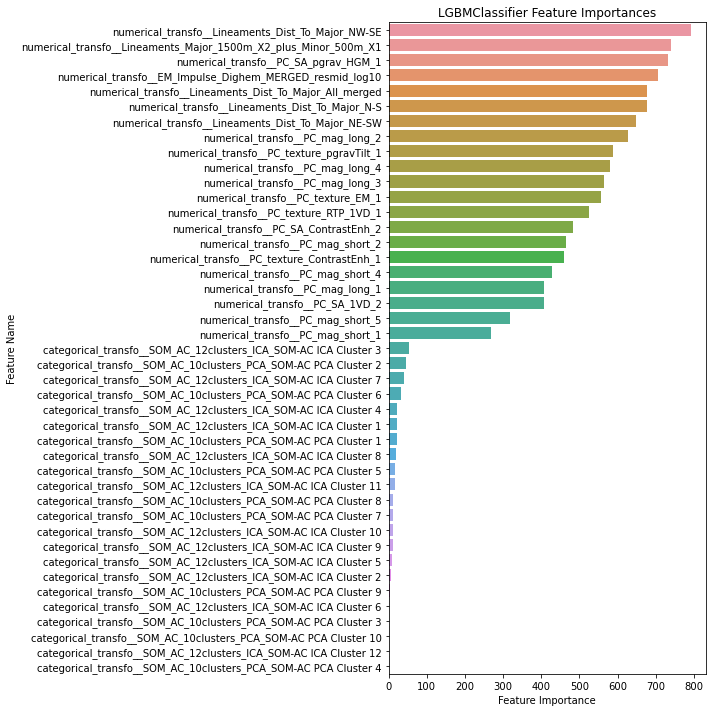

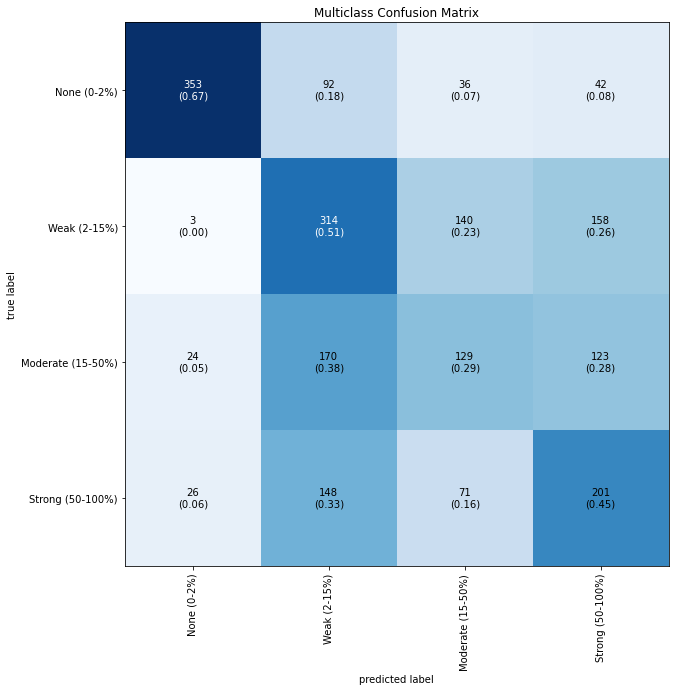

inferred resolution from coordinates is 25.0

6 geotiffs written.
../3_processing/2_baseline_model_outputs\LightGBM\LightGBM_CMP_Class_1.tif
../3_processing/2_baseline_model_outputs\LightGBM\LightGBM_CMP_Class_2.tif
../3_processing/2_baseline_model_outputs\LightGBM\LightGBM_CMP_Class_3.tif
../3_processing/2_baseline_model_outputs\LightGBM\LightGBM_CMP_Class_4.tif
../3_processing/2_baseline_model_outputs\LightGBM\LightGBM_predictions.tif
../3_processing/2_baseline_model_outputs\LightGBM\LightGBM_entropy.tif

Baseline analysis and predictions for : RandomForests
              precision  recall  f1-score  support
1                0.8037  0.6577    0.7234    523.0
2                0.4407  0.5138    0.4745    615.0
3                0.3671  0.3251    0.3448    446.0
4                0.3327  0.3655    0.3483    446.0
macro avg        0.4861  0.4655    0.4728   2030.0
weighted avg     0.4943  0.4768    0.4824   2030.0
Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('n

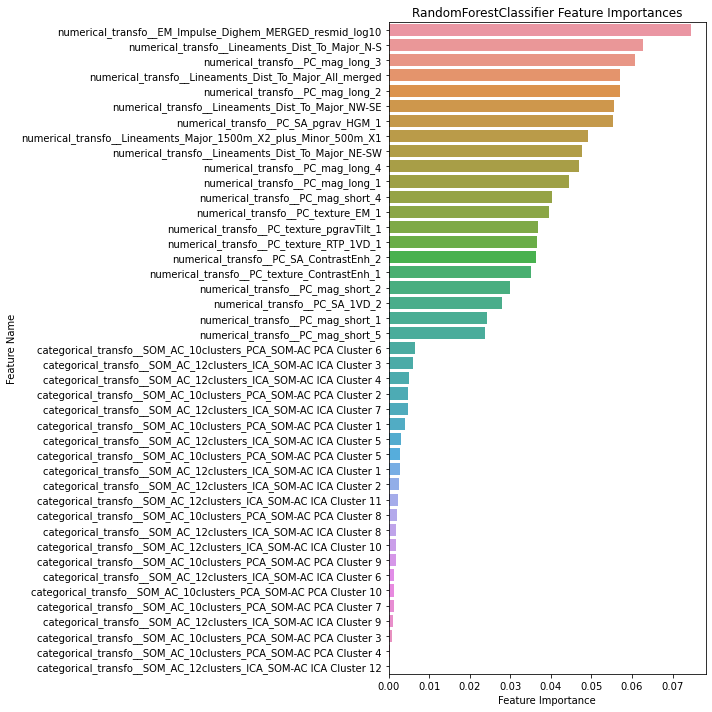

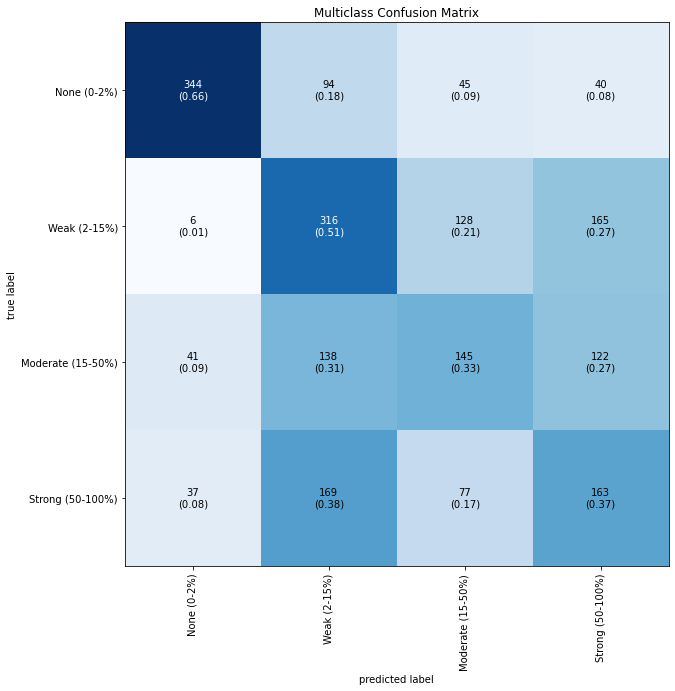

inferred resolution from coordinates is 25.0

6 geotiffs written.
../3_processing/2_baseline_model_outputs\RandomForests\RandomForests_CMP_Class_1.tif
../3_processing/2_baseline_model_outputs\RandomForests\RandomForests_CMP_Class_2.tif
../3_processing/2_baseline_model_outputs\RandomForests\RandomForests_CMP_Class_3.tif
../3_processing/2_baseline_model_outputs\RandomForests\RandomForests_CMP_Class_4.tif
../3_processing/2_baseline_model_outputs\RandomForests\RandomForests_predictions.tif
../3_processing/2_baseline_model_outputs\RandomForests\RandomForests_entropy.tif

Baseline analysis and predictions for : XGBoost


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[11:32:31] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision  recall  f1-score  support
1                0.8388  0.6367    0.7239    523.0
2                0.4277  0.4764    0.4508    615.0
3                0.3347  0.3677    0.3504    446.0
4                0.4301  0.4417    0.4358    446.0
macro avg        0.5078  0.4806    0.4902   2030.0
weighted avg     0.5137  0.4862    0.4958   2030.0
Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('numerical_transfo',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000028F8CEA

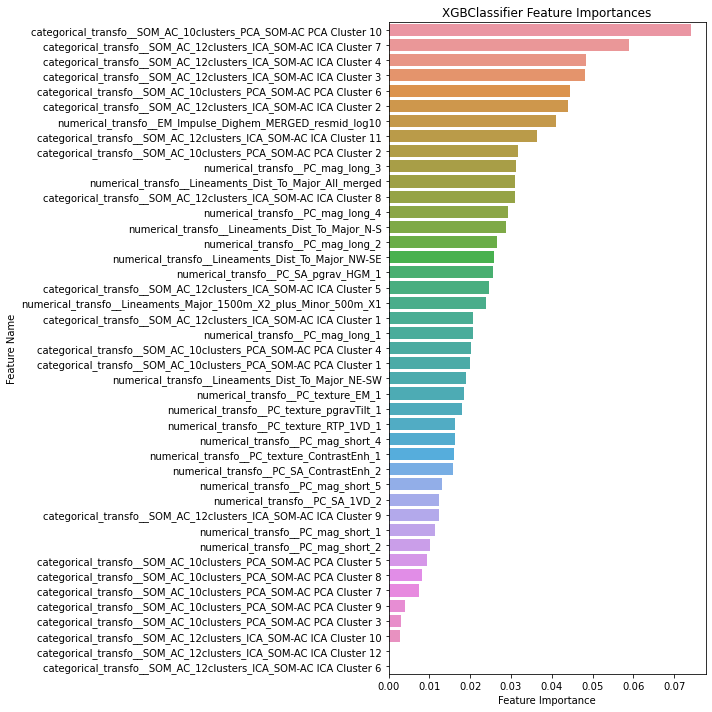

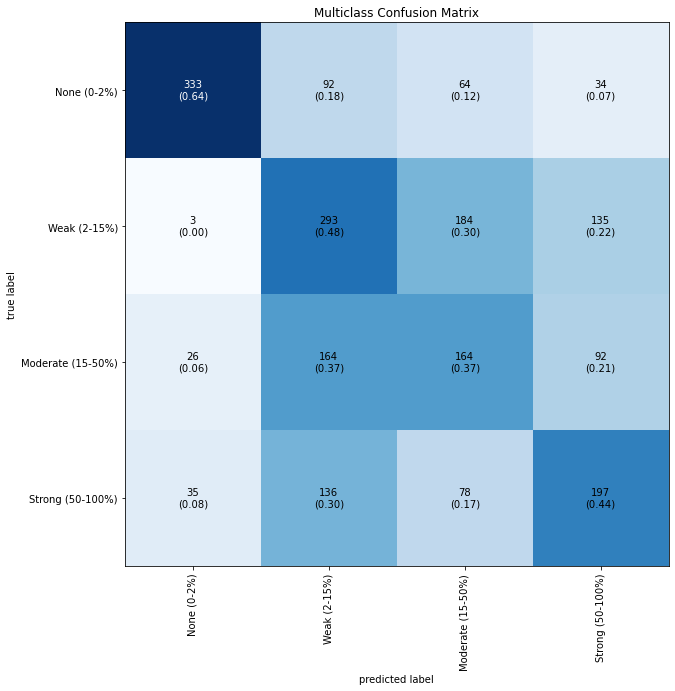

inferred resolution from coordinates is 25.0

6 geotiffs written.
../3_processing/2_baseline_model_outputs\XGBoost\XGBoost_CMP_Class_1.tif
../3_processing/2_baseline_model_outputs\XGBoost\XGBoost_CMP_Class_2.tif
../3_processing/2_baseline_model_outputs\XGBoost\XGBoost_CMP_Class_3.tif
../3_processing/2_baseline_model_outputs\XGBoost\XGBoost_CMP_Class_4.tif
../3_processing/2_baseline_model_outputs\XGBoost\XGBoost_predictions.tif
../3_processing/2_baseline_model_outputs\XGBoost\XGBoost_entropy.tif



In [44]:
for i, pipe in enumerate(my_pipes):
    print('Baseline analysis and predictions for : ' + my_pipes_names[i])
    
    #########################################
    ##### PIPELINE FITTING & PREDICTION #####
    #########################################
    pipe_alg = pipe
    pipe_alg.fit(X_train, y_train)
    test_preds = pipe_alg.predict(X_test)
    
    #################################
    ##### CLASSIFICATION REPORT #####
    #################################
    report = classification_report(y_test, test_preds.ravel(), target_names = classes, output_dict = True)
    df = pd.DataFrame(report).transpose()
    df.drop(index='accuracy', inplace = True)
    df = df.round({'precision': 4, 'recall': 4, 'f1-score': 4})
    df.to_csv(os.path.join(trial_name, my_pipes_names[i], my_pipes_names[i] + '_testing_performance.csv'))
    print(df)
    
    ###############################
    ##### FEATURE IMPORTANTCE #####
    ###############################
    
            ####** Can use SHAP when there are no categorical data **####
    #shap_values = shap.TreeExplainer(pipe_alg['clf']).shap_values(X_train)
    #shap.summary_plot(shap_values, X_train, plot_type="bar", class_names = class_names, max_display = 51, show = False)
    #plt.savefig(os.path.join(trial_name, my_pipes_names[i], my_pipes_names[i] + '_SHAP.png'), dpi = 600, facecolor = 'white', bbox_inches="tight")
    #plt.close()
    print(pipe_alg)
    feat_imp.plot_feature_importance(model = pipe_alg,
                                     #combine_cat_class_importances = True,
                                     output_directory = os.path.join(trial_name, my_pipes_names[i]), 
                                     title = '/' + my_pipes_names[i] + '_Feature_Importances_Combined.png')
    
    ########################################
    ##### CONFUSION MATRICES (TESTING) #####
    ########################################
    reporting.multiclass_confusion_matrix_plot(y_test, test_preds.ravel(), class_names, os.path.join(trial_name, my_pipes_names[i]))
    
    ###########################
    ##### GEOTIFF OUTPUTS #####
    ###########################
    prob_class = [(my_pipes_names[i] + '_CMP_Class_' + str(classes[j])) for j in range(num_class)]
    all_predictions = pipe_alg.predict(all_X)
    all_predicted_prob = pipe_alg.predict_proba(all_X)
    
    predictions = cube.subset(['coordinates'])
    predictions[prob_class] = all_predicted_prob
    predictions[my_pipes_names[i] + '_predictions'] = all_predictions
    predictions[my_pipes_names[i] + '_entropy'] = entropy(all_predicted_prob, axis = 1)/np.log(num_class)
    out_files = list(predictions.columns[2:]) #Ignoring the 'x' and 'y' columns
    
    utilities.df_to_gtiffs(df = predictions, crs = crs, outfolder = os.path.join(trial_name, my_pipes_names[i]), x_col = 'x', y_col = 'y',
                           features = out_files, nodata = -9999, verbose = True)
    print('')